<a href="https://colab.research.google.com/github/astro-informatics/harmonic/blob/main/notebooks/basic_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://raw.githubusercontent.com/astro-informatics/harmonic/fa99200ddd9c942921439cfbadf30c6ede7226f3/docs/assets/harm_badge_simple.svg" width="250" height="250"/>

# [`harmonic`](https://github.com/astro-informatics/harmonic) - __Basic Usage__ Interactive Tutorial
---

In this interactive tutorial we demonstrate basic usage of `harmonic`, using [`emcee`](https://emcee.readthedocs.io/en/stable/) as the sampler.





In [1]:
if 'google.colab' in str(get_ipython()):
    %%capture
    # Install packages
    %pip install harmonic emcee getdist

In [2]:
%%capture
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import harmonic as hm
from functools import partial
import emcee
import jax.numpy as jnp

# Define Bayesian posterior function
---

Now we will need to define the log-posterior function of interest. 

As a working example for this basic tutorial we consider a log-likelihood given a standard 2-dimensional Gaussian

$$
f(x) = -\frac{1}{2}x^{T}\Sigma^{-1}x
$$

where for simplicity we have taken the mean $\mu=0$ and dropped scaling factors, and assume a trivial uniform prior over an infinite interval. Under such conditions the log-posterior is given by

In [3]:
def ln_posterior(x, inv_cov):
    """Compute log_e of posterior of n dimensional multivariate Gaussian.

    Args:

        x: Position at which to evaluate posterior.

    Returns:

        double: Value of posterior at x.

    """

    return -jnp.dot(x,jnp.dot(inv_cov,x))/2.0

# Compute samples using `emcee`
---

We then sample from the posterior using an MCMC algorithm. While any MCMC approach can be used we sample using the `emcee` package.

First we will need to define and initialise some variables.

In [4]:
# Define parameters for emcee sampling
ndim = 5                    # Dimensions
nchains = 30                # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Construct a trivial inverse covariance (identity matrix)
inv_cov = np.zeros((ndim,ndim))
diag_cov = np.ones(ndim)
np.fill_diagonal(inv_cov, diag_cov) 

Now we need to run the sampler.

In [5]:
# initialise random seed
np.random.seed(1)

# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) 
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[inv_cov])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

# Compute evidence using `harmonic`
---

`harmonic` requires only posterior samples.  There are no constraints on the type of sampling algorithm used.

Once we have posterior samples to hand, they can be post-processed using `harmonic` to compute the Bayesian evidence.

## Collating samples using `harmonic.chains` class

We first configure the chains into a `harmonic`-friendly shape, which we do as follows.

In [6]:
# Instantiate harmonic's chains class 
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)

Since we will subsequently learn the target distribution $\varphi$ we split the samples into training and inference sets (we often use the common machine learning terminology "test" for the inference data-set).

In [7]:
# Split the chains into the ones which will be used to train the machine 
# learning model and for inference
chains_train, chains_infer = hm.utils.split_data(chains, training_proportion=0.5)

## Train the machine learning model

We simply select the model we wish to adopt and fit the model.

In [8]:
# Select RQSpline Model
temperature = 0.8
model = hm.model.RQSplineModel(ndim, standardize=True, temperature=temperature)
epochs_num = 15
# Train model
model.fit(chains_train.samples, epochs=epochs_num, verbose= True)

Training NF: 100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


## Posterior triangle plot

Let's also plot slices of the posterior using these samples to see what we're working with! It is important for the concentrated flow (here we set temperature equal to 0.8) to be contained within the posterior. If this is not the case, the evidence estimate will not be accurate. If the flow is not contained within the posterior, try reducing the temperature or learning the posterior better by training for longer or changing the model architecture or hyperparameters.

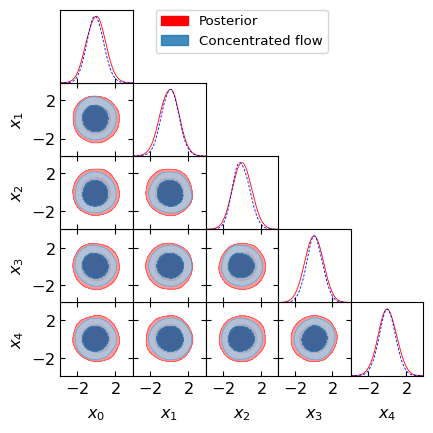

In [9]:
samples = samples.reshape((-1, ndim))
samp_num = samples.shape[0]
flow_samples = model.sample(samp_num)
hm.utils.plot_getdist_compare(samples, flow_samples)

## Compute the Bayesian evidence

Finally we simply compute the learnt harmonic mean estimator as follows.

In [10]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_infer.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_infer)
ln_inv_evidence = ev.ln_evidence_inv
err_ln_inv_evidence = ev.compute_ln_inv_evidence_errors()

# Results
---

Let's check the evidence value computed.

## Analytic value

As this is a standard 2-dimensional Gaussian the evidence is analytically tractable and given by

In [11]:
def ln_analytic_evidence(ndim, cov):
    """Compute analytic evidence for nD Gaussian.

    Args:

        ndim: Dimension of Gaussian.

        cov: Covariance matrix.

    Returns:

        double: Analytic evidence.

    """
    
    ln_norm_lik = 0.5*ndim*np.log(2*np.pi) + 0.5*np.log(np.linalg.det(cov))
    return ln_norm_lik

ln_inv_evidence_analytic = -ln_analytic_evidence(ndim, inv_cov)

Let's compare the value computed by `harmonic` and analytically

In [12]:
print('ln inverse evidence (harmonic) = {} +/- {}'.format(ln_inv_evidence, err_ln_inv_evidence))
print('ln inverse evidence (analytic) = {}'.format(ln_inv_evidence_analytic))
print('nsigma = {}'.format(np.abs(ln_inv_evidence - ln_inv_evidence_analytic) / err_ln_inv_evidence))

ln inverse evidence (harmonic) = -4.588324546813965 +/- (np.float32(-0.007659368), np.float32(0.0076011475))
ln inverse evidence (analytic) = -4.594692666023363
nsigma = [-0.83141573  0.83778393]


As expected, the evidence computed by `harmonic` is close to that computed analytically.